In [1]:
%matplotlib inline

import numpy as np

import matplotlib.image as mpimg

import matplotlib.pyplot as plt

import matplotlib.cm as cm

import png

import scipy.ndimage as ndimage

from scipy.misc import imsave, imshow

from scipy.ndimage import filters

import pyopencl as cl

In [2]:
# Our starting image
img = ndimage.imread('./eed-noise.png')
# extract red channel
img = img[:,:,0]
height, width = img.shape

In [3]:
def show(img, height=height, width=width):
    plt.imshow(img.reshape(height,width), cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

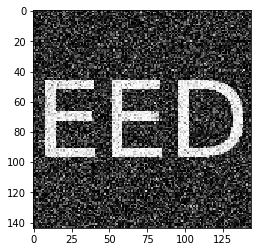

In [4]:
show(img)

In [5]:
def createBlurMask(sigma):
    maskSize = int(np.ceil(3.0*sigma))
    mask = np.zeros((maskSize*2+1, maskSize*2+1))
    
    maskSum = 0.0
    for a in xrange(-maskSize, maskSize+1):
        for b in xrange(-maskSize, maskSize+1):
            temp = np.exp(-( float(a*a + b*b) / (2*sigma*sigma) ))
            maskSum += temp
            mask[a+maskSize, b+maskSize] = temp
            
    # Normalize
    mask = mask / maskSum
    
    return mask, maskSize
    
    

<pyopencl.Context at 0x7ff1389d2ee0 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
(144, 144)


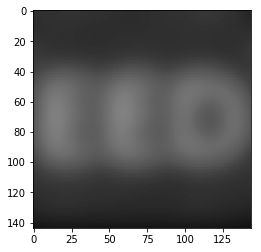

In [10]:
mask, maskSize = createBlurMask(10.0)

#ctx = cl.create_some_context()
platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.GPU,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print ctx
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags

#img_g = cl.image_from_array(ctx, np.asarray(img.astype(np.float32)))
img_g = cl.Buffer(ctx, mf.READ_ONLY  | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
blurred_img_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
mask_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=mask.astype(np.float32))

prg = cl.Program(ctx, """
__kernel void gaussian_blur(__global float * img_g, __constant float * mask, __private const int maskSize,
                            __global float * blurred_img_g)
{
  const int posx = get_global_id(0);
  const int posy = get_global_id(1);
  
  float sum = 0.0f;
  
  for (int a = -maskSize; a < maskSize+1; a++) {
    for (int b = -maskSize; b < maskSize+1; b++) {
      const int imgpos = clamp(posx+a, 0, 144) + clamp(posy+b, 0, 144)*144;
      sum += mask[a+maskSize + (b+maskSize)*(maskSize*2+1)] * img_g[imgpos];
    }
  }
  
  blurred_img_g[posx+posy*get_global_size(0)] = sum;
}


""").build()

kernel = prg.gaussian_blur
kernel.set_scalar_arg_dtypes( [None, None, np.int32, None] )
kernel(queue, img.shape, None, img_g, mask_g, maskSize, blurred_img_g)

result_np = np.empty_like(img).astype(np.float32)
cl.enqueue_copy(queue, result_np, blurred_img_g)

# Show results
show(result_np)
print result_np.shape

In [9]:
cl.get_platforms()[0].get_devices()

[<pyopencl.Device 'Intel(R) Core(TM) i7-5557U CPU @ 3.10GHz' on 'Apple' at 0xffffffff>,
 <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>]

In [30]:
cl.get_supported_image_formats(ctx, cl.mem_flags.READ_ONLY, cl.mem_object_type.IMAGE2D)

[ImageFormat(INTENSITY, FLOAT),
 ImageFormat(RGBA, FLOAT),
 ImageFormat(RGBx, FLOAT),
 ImageFormat(RGx, FLOAT),
 ImageFormat(Rx, FLOAT),
 ImageFormat(INTENSITY, HALF_FLOAT),
 ImageFormat(RGBA, HALF_FLOAT),
 ImageFormat(RGBx, HALF_FLOAT),
 ImageFormat(RGBA, <unknown channel data type 0x10000008>),
 ImageFormat(RGBA, SIGNED_INT16),
 ImageFormat(RGBA, SIGNED_INT32),
 ImageFormat(RGBA, SIGNED_INT8),
 ImageFormat(RGBA, SNORM_INT16),
 ImageFormat(RGBA, SNORM_INT8),
 ImageFormat(RGBA, UNSIGNED_INT16),
 ImageFormat(RGBA, UNSIGNED_INT32),
 ImageFormat(RGBA, UNSIGNED_INT8),
 ImageFormat(RGBA, UNORM_INT16),
 ImageFormat(RGBx, UNORM_INT16),
 ImageFormat(<unknown channel order 0x10000006>, UNORM_INT8),
 ImageFormat(A, UNORM_INT8),
 ImageFormat(<unknown channel order 0x10b7>, UNORM_INT8),
 ImageFormat(<unknown channel order 0x10000007>, UNORM_INT8),
 ImageFormat(BGRA, UNORM_INT8),
 ImageFormat(INTENSITY, UNORM_INT8),
 ImageFormat(RGBA, UNORM_INT8),
 ImageFormat(RGBx, UNORM_INT8),
 ImageFormat(RGx, U